<a href="https://colab.research.google.com/github/trista-paul/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/Trista_GAN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [1]:
!pip install emoji_data_python

In [2]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

--2019-05-15 19:12:16--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip [following]
--2019-05-15 19:12:16--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3407395 (3.2M) [application/zip]
Saving to: ‘emoji.zip.1’

emoji.zip.1         

In [0]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [4]:
#images in color have 3 dimensions and will need convolutional 
example_emoji.shape

(28, 28, 4)

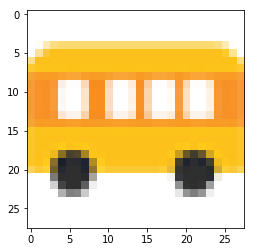

In [5]:
plt.imshow(example_emoji);

In [6]:
#images in greyscale have 2 dimensions and can use binary
grayscale_emoji.shape

(28, 28)

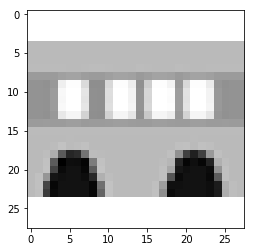

In [7]:
plt.imshow(grayscale_emoji, cmap="gray");

# Convert the images

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
emojis = os.listdir('emoji')
emojis

In [0]:
#we need to make the colored images greyscale
#make a function and loop it for everything in emojis
bw_emoji = []
#'emoji/1f683.png'
for png in emojis:
  #read image
  png_array = imageio.imread('emoji/'+str(png))
  #reshape the array to be 2d
  png_array = color.rgb2gray(png_array)
  print(png_array.shape)
  bw_emoji.append(png_array) #they're all 28*28

In [36]:
len(bw_emoji)

861

In [40]:
#convert bw_emoji to array
bw_emoji = np.asarray(bw_emoji)
bw_emoji

array([[[1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 0.76189922, 0.76189922, ..., 0.76189922,
         0.76189922, 1.        ],
        [1.        , 0.76189922, 0.76189922, ..., 0.76189922,
         0.76189922, 1.        ],
        ...,
        [1.        , 0.76189922, 0.76189922, ..., 0.76189922,
         0.76189922, 1.        ],
        [1.        , 0.76189922, 0.76189922, ..., 0.76189922,
         0.76189922, 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]],

       [[0.51406471, 0.51406471, 0.51406471, ..., 0.18431373,
         0.18431373, 1.        ],
        [0.51406471, 0.51406471, 0.51406471, ..., 0.18431373,
         0.18431373, 1.        ],
        [0.51406471, 0.51406471, 0.51406471, ..., 0.18431373,
         0.18431373, 1.        ],
        ...,
        [0.18431373, 0.18431373, 0.18431373, ..., 0.18431373,
         0.18431373, 1.        ],
        [0.1

In [41]:
bw_emoji.shape

(861, 28, 28)

In [43]:
bw_emoji_normalize = (bw_emoji.astype(np.float32) - 127.5)/127.5
bw_emoji_normalize

array([[[-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
         -0.99215686, -0.99215686],
        [-0.99215686, -0.9940243 , -0.9940243 , ..., -0.9940243 ,
         -0.9940243 , -0.99215686],
        [-0.99215686, -0.9940243 , -0.9940243 , ..., -0.9940243 ,
         -0.9940243 , -0.99215686],
        ...,
        [-0.99215686, -0.9940243 , -0.9940243 , ..., -0.9940243 ,
         -0.9940243 , -0.99215686],
        [-0.99215686, -0.9940243 , -0.9940243 , ..., -0.9940243 ,
         -0.9940243 , -0.99215686],
        [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
         -0.99215686, -0.99215686]],

       [[-0.99596816, -0.99596816, -0.99596816, ..., -0.9985544 ,
         -0.9985544 , -0.99215686],
        [-0.99596816, -0.99596816, -0.99596816, ..., -0.9985544 ,
         -0.9985544 , -0.99215686],
        [-0.99596816, -0.99596816, -0.99596816, ..., -0.9985544 ,
         -0.9985544 , -0.99215686],
        ...,
        [-0.9985544 , -0.9985544 , -0.9985544 , ..., -

In [44]:
bw_emoji_reshape = bw_emoji_normalize.reshape(861, 784)
bw_emoji_reshape

array([[-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
        -0.99215686, -0.99215686],
       [-0.99596816, -0.99596816, -0.99596816, ..., -0.9985544 ,
        -0.9985544 , -0.99215686],
       [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
        -0.99215686, -0.99215686],
       ...,
       [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
        -0.99215686, -0.99215686],
       [-0.99215686, -0.99215686, -0.99215686, ..., -0.99215686,
        -0.99215686, -0.99215686],
       [-0.99215686, -0.99215686, -0.9969245 , ..., -0.9969245 ,
        -0.99215686, -0.99215686]], dtype=float32)

### shape of fashion mnist (reference)

In [23]:
#what is the input we worked with in lecture?
from keras.datasets import fashion_mnist
fashion = fashion_mnist.load_data()
fashion #an array of arrays

((array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         ...,
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],
  
         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0

In [25]:
len(fashion) #a tuple containing arrays

2

In [26]:
print(len(fashion[0]), len(fashion[1])) #of course
#first tuple (train, test)
#second tuples (xtrain, ytrain), (xtest, ytest)

2 2


In [34]:
print(fashion[0][0].shape) #yup, there's the arrays
print(fashion[0][1].shape)

(60000, 28, 28)
(60000,)


In [38]:
x_train = fashion[0][0] #we ignore everything else in mnist

# normalize our inputs to be in the range[-1, 1]
x_train = (x_train.astype(np.float32) - 127.5)/127.5
x_train

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        ...,
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]],

       ...,

       [[-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.

In [39]:
# convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
# 784 columns per row
x_train = x_train.reshape(60000, 784)
x_train

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)

# BW GAN Model

In [0]:
#discriminator - binary classification NN
#stretch goal: modify to accept convolutions
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784, #ie 28*28
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [0]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [0]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [0]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train = bw_emoji_reshape
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

# Result

In [0]:
np.random.seed(10)
random_dim = 100

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/6 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


 17%|█▋        | 1/6 [00:00<00:00,  6.66it/s]

--------------- Epoch 2 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.24it/s]

--------------- Epoch 3 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.13it/s]

--------------- Epoch 4 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.46it/s]

--------------- Epoch 5 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.23it/s]

--------------- Epoch 6 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.24it/s]

--------------- Epoch 7 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.18it/s]

--------------- Epoch 8 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.46it/s]

--------------- Epoch 9 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.23it/s]

--------------- Epoch 10 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.31it/s]

--------------- Epoch 11 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.15it/s]

--------------- Epoch 12 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.19it/s]

--------------- Epoch 13 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.34it/s]

--------------- Epoch 14 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.20it/s]

--------------- Epoch 15 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.33it/s]

--------------- Epoch 16 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.25it/s]

--------------- Epoch 17 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.07it/s]

--------------- Epoch 18 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.03it/s]

--------------- Epoch 19 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.88it/s]

--------------- Epoch 20 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.78it/s]

--------------- Epoch 21 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.13it/s]

--------------- Epoch 22 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.91it/s]

--------------- Epoch 23 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.18it/s]

--------------- Epoch 24 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.17it/s]

--------------- Epoch 25 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.02it/s]

--------------- Epoch 26 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.38it/s]

--------------- Epoch 27 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

--------------- Epoch 28 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.99it/s]

--------------- Epoch 29 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.01it/s]

--------------- Epoch 30 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.21it/s]

--------------- Epoch 31 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  6.75it/s]

--------------- Epoch 32 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.16it/s]

--------------- Epoch 33 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.20it/s]

--------------- Epoch 34 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.08it/s]

--------------- Epoch 35 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.23it/s]

--------------- Epoch 36 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.21it/s]

--------------- Epoch 37 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.26it/s]

--------------- Epoch 38 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.35it/s]

--------------- Epoch 39 ---------------


 17%|█▋        | 1/6 [00:00<00:00,  7.20it/s]

--------------- Epoch 40 ---------------


100%|██████████| 6/6 [00:00<00:00,  7.13it/s]


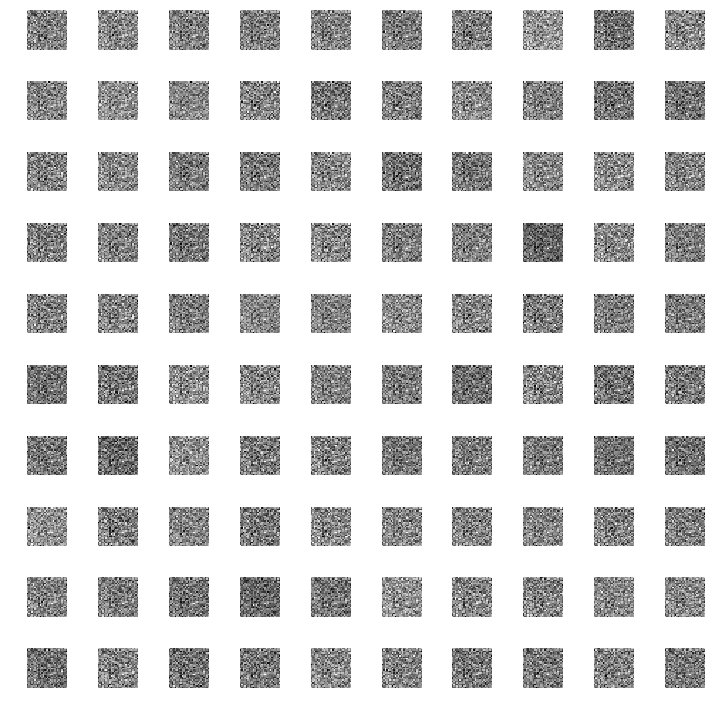

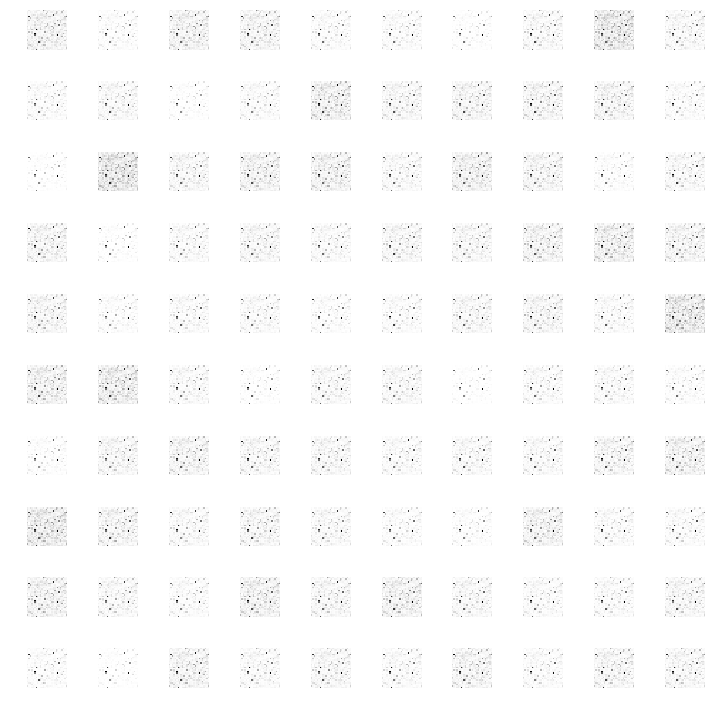

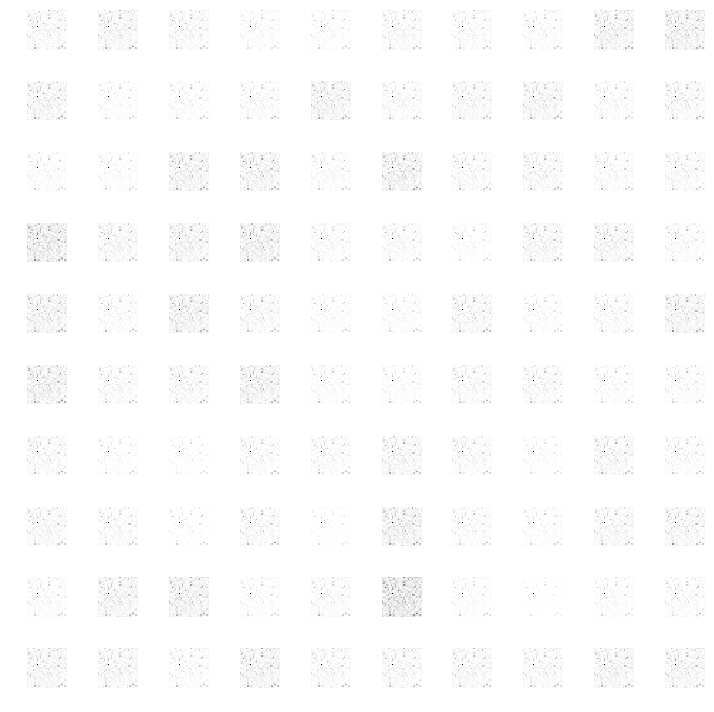

In [48]:
train(40, 128)